# Sprint 4 - Model evaluation for Missing GHG values

In this notebook, we present the four predictive models we worked on. The goal of these models is to populate missing GHG values in our dataset. 

## Feauture Engineering

Before coding the models, we will create two new variables in our dataset. 

1. Missing_GHG - Boolean indicating if the stock had a missing value in that year (1 = True / 0 = False)
2. Utilities - Boolean indicating if it is a Utility company (1 = True / 0 = False)
3. Time Trend - Cumulative value (0,1,2,3) for each year the stock is in the dataset.

The second variable will be used in the Model #3 and #4

#### Missing_GHG

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import scale 

stocks = pd.read_csv(r"C:\Users\YEET\Documents\GitHub\Predicting-Environmental-and-Social-Actions\Datasets\company_data.csv")
sectors = pd.read_csv(r"C:\Users\YEET\Documents\GitHub\Predicting-Environmental-and-Social-Actions\Datasets\52_tickers_sectors.csv")

stocks['Missing_GHG'] = np.where(stocks['GHG Scope 1'].isna(), 1, 0)
stocks.loc[stocks['GHG Scope 1'].isna(),['GHG Scope 1','Missing_GHG']].head()

,GHG Scope 1,Missing_GHG
0,NaN,1
1,NaN,1
2,NaN,1
3,NaN,1
4,NaN,1


#### Utilities

In [2]:
df = pd.merge(stocks, sectors, how='inner',on='Ticker')
df.drop(columns='Name', inplace=True)
stocks = df.copy()
stocks['Utility'] = np.where(stocks.Sector == 'Utilities',1,0)
stocks.loc[stocks.Sector == 'Utilities',].head()

,Year,Ticker,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Change_in_TEC,Ratio of GHG Emissions to Total Assets,Ratio of GHG Emissions to Total Sales,...,Change_in_NI,ROA,Profit_Margin,Annual Return,Logarithm_Total_Assets,Logarithm_Total_Sales,Profitable,Missing_GHG,Sector,Utility
0,2005,AEE,NaN,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,...,0.000000,3.408215,9.129794,NaN,9.807087,8.821732,True,1,Utilities,1
1,2006,AEE,NaN,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,...,-9.854604,2.850138,8.110465,NaN,9.882162,8.836374,True,1,Utilities,1
2,2007,AEE,9.7,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,...,12.724014,3.034543,8.335542,NaN,9.939241,8.928773,True,1,Utilities,1
3,2008,AEE,9.7,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,...,-2.225755,2.714393,7.845388,NaN,10.028224,8.966867,True,1,Utilities,1
4,2009,AEE,12.4,NaN,NaN,27.835052,0.0,0.0,NaN,NaN,...,-0.487805,2.572509,8.631876,NaN,10.077021,8.866441,True,1,Utilities,1


#### Time trend

In [3]:
stocks['time_trend'] = stocks.groupby('Ticker').cumcount()
stocks.loc[stocks.Ticker == 'XOM'].groupby(['Ticker','Year']).head(20)

,Year,Ticker,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Change_in_TEC,Ratio of GHG Emissions to Total Assets,Ratio of GHG Emissions to Total Sales,...,ROA,Profit_Margin,Annual Return,Logarithm_Total_Assets,Logarithm_Total_Sales,Profitable,Missing_GHG,Sector,Utility,time_trend
765,2005,XOM,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,...,17.342261,11.008095,NaN,12.246903,12.701418,True,1,Energy,0,0
766,2006,XOM,43.8,145500.0,433650.0,0.000000,0.000000,0.000000,664.338059,434.216888,...,18.035294,11.788019,NaN,12.296895,12.722142,True,0,Energy,0,1
767,2007,XOM,46.3,141000.0,430556.0,5.707763,-3.092784,-0.713479,582.447270,393.195761,...,16.775308,11.324596,NaN,12.397032,12.789963,True,0,Energy,0,2
768,2008,XOM,46.3,126000.0,416667.0,0.000000,-10.638298,-3.225829,552.505569,296.421068,...,19.828811,10.638223,NaN,12.337329,12.960011,True,0,Energy,0,3
769,2009,XOM,52.9,128000.0,405639.0,14.254860,1.587302,-2.646718,548.595724,464.501894,...,8.263223,6.996560,NaN,12.360179,12.526575,True,0,Energy,0,4
770,2010,XOM,54.6,132000.0,408333.0,3.213611,3.125000,0.664137,436.349212,386.441750,...,10.069089,8.917436,NaN,12.619870,12.741331,True,0,Energy,0,5
771,2011,XOM,54.6,136000.0,430556.0,0.000000,3.030303,5.442372,410.811595,313.706675,...,12.402885,9.471174,NaN,12.710031,12.979707,True,0,Energy,0,6
772,2012,XOM,55.4,132000.0,416667.0,1.465201,-2.941176,-3.225829,395.452299,313.752335,...,13.445378,10.667579,0.198270,12.718282,12.949709,True,0,Energy,0,7
773,2013,XOM,55.4,135000.0,416667.0,0.000000,2.272727,0.000000,389.264377,345.934754,...,9.394247,8.348559,0.120157,12.756527,12.874535,True,0,Energy,0,8
774,2014,XOM,55.4,121000.0,444444.0,0.000000,-10.370370,6.666475,346.215804,331.722242,...,9.304907,8.915378,0.352835,12.764239,12.807003,True,0,Energy,0,9


## Models

### Model 1 - Sales and Assets


GHG = a + b1*Sales + b2*Assets + e     


In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [5]:
df= stocks
df.columns

Index(['Year', 'Ticker', 'Environmental Disclosure Score', 'GHG Scope 1',
       'Total Energy Consumption', 'Change_in_EDS', 'Change_in_GHG',
       'Change_in_TEC', 'Ratio of GHG Emissions to Total Assets',
       'Ratio of GHG Emissions to Total Sales',
       'Ratio of Total Energy Consumption to Total Assets',
       'Ratio of Total Energy Consumption to Total Sales', 'cusip', 'Company',
       'Total_Assets', 'Net_Income', 'Total_Sales', 'cik', 'Change_in_Sales',
       'Change_in_Assets', 'Change_in_NI', 'ROA', 'Profit_Margin',
       'Annual Return', 'Logarithm_Total_Assets', 'Logarithm_Total_Sales',
       'Profitable', 'Missing_GHG', 'Sector', 'Utility', 'time_trend'],
      dtype='object')

In [6]:
da=df[['GHG Scope 1','Total_Assets','Total_Sales']]

In [7]:
dn=da.dropna()
dn

,GHG Scope 1,Total_Assets,Total_Sales
8,32978.0,21042.0,5838.0
9,30675.0,22676.0,6053.0
10,28548.2,23640.0,6098.0
11,26795.6,24699.0,6076.0
12,30200.4,25945.0,6177.0
...,...,...,...
775,118000.0,336758.0,236810.0
776,120000.0,330314.0,197518.0
777,117000.0,348691.0,237162.0
778,119000.0,346196.0,279332.0


In [8]:
X = dn.iloc[:, 1:3].values
y = dn.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [9]:
print(regressor.intercept_)

8051.399968329071


In [10]:
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
0,3577.3,15212.450226
1,119000.0,129202.217025
2,3410.0,15292.058240
3,14296.5,13591.750163
4,32000.0,18793.153300
...,...,...
75,19503.9,16332.792194
76,3200.0,18700.183593
77,31207.0,17774.777860
78,42354.9,22217.844498


In [11]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 18676.830253094093
Mean Squared Error: 596373921.6269232
Root Mean Squared Error: 24420.768243995175


In [12]:
r2 = regressor.score(X_train, y_train)
print('R^2: {0}'.format(r2))

R^2: 0.43150016760444276


In [13]:
df_model_eval = pd.DataFrame({'Model': 'Linear (Sales + Asset)','MSE': metrics.mean_squared_error(y_test, y_pred), 'RMSE' :np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 'R-Squared' :  metrics.r2_score(y_test, y_pred)}, index=[0])

df_model_eval

,Model,MSE,RMSE,R-Squared
0,Linear (Sales + Asset),5.963739e+08,24420.768244,0.547856


### Model 2 - Logarithm Sales and Assets

ln(GHG) = a0 + b10*ln(Sales) + b20*ln(Assets) + e

In [14]:
# import matplotlib.pyplot as plt
# import missingno as msno
# from datetime import datetime, date
# from sklearn.feature_selection import RFE
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn import linear_model
# from sklearn import metrics



In [15]:
stocks.columns

Index(['Year', 'Ticker', 'Environmental Disclosure Score', 'GHG Scope 1',
       'Total Energy Consumption', 'Change_in_EDS', 'Change_in_GHG',
       'Change_in_TEC', 'Ratio of GHG Emissions to Total Assets',
       'Ratio of GHG Emissions to Total Sales',
       'Ratio of Total Energy Consumption to Total Assets',
       'Ratio of Total Energy Consumption to Total Sales', 'cusip', 'Company',
       'Total_Assets', 'Net_Income', 'Total_Sales', 'cik', 'Change_in_Sales',
       'Change_in_Assets', 'Change_in_NI', 'ROA', 'Profit_Margin',
       'Annual Return', 'Logarithm_Total_Assets', 'Logarithm_Total_Sales',
       'Profitable', 'Missing_GHG', 'Sector', 'Utility', 'time_trend'],
      dtype='object')

In [16]:
model_df = stocks[['Total_Sales', 'Total_Assets', 'GHG Scope 1']].copy()
model_df.dropna(inplace = True)

x = np.log(model_df[['Total_Sales', 'Total_Assets']])
y = np.log(model_df['GHG Scope 1'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
clf = LinearRegression().fit(X_train, y_train)
# y_pred = clf.predict(X_test)
y_pred = np.exp(clf.predict(X_test))
y_test = np.exp(y_test)

In [17]:
#The coefficients
print('Coefficients: \n', clf.coef_)
#Mean Squared Error
print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test,y_pred))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test,y_pred))}')
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % metrics.r2_score(y_test, y_pred))

Coefficients: 
 [0.10981093 0.73993793]
Mean squared error: 796139917.35
Root Mean Squared Error: 28215.951469835443
Coefficient of determination: 0.40


In [18]:
log_reg = pd.DataFrame({'Observed':y_test,'Prediction':y_pred})
log_reg.head()

,Observed,Prediction
418,3577.3,7113.041245
778,119000.0,84476.890735
58,3410.0,7266.676969
464,14296.5,5567.369424
206,32000.0,10140.048533


In [19]:
df_model_eval.loc[len(df_model_eval.index)] = ['Logarithmic (Sales + Asset)', metrics.mean_squared_error(y_test,y_pred), np.sqrt(metrics.mean_squared_error(y_test,y_pred)), metrics.r2_score(y_test, y_pred)] 

### Model 3 -  GHG for Energy vs Utilities

GHG = a + b1*Sales + b2*Assets + b3*Util + b5*TimeTrend + e

#### Linear Regression - Validation set approach

In [20]:
stock = stocks.copy()
stock.dropna(inplace=True, subset = ['Total_Assets','Total_Sales','GHG Scope 1'])

X = stock[['Total_Sales','Total_Assets','Utility','time_trend']]
y = stock['GHG Scope 1']
print(X.shape)
print(y.shape)

(398, 4)
(398,)


In [21]:
model = LinearRegression(fit_intercept=True) #Initialize model
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42) #Train and Test split
model.fit(Xtrain,ytrain) #Fit the model
y_model = model.predict(Xtest) #Make predictions

In [22]:
#The coefficients
print('Coefficients: \n', model.coef_)
#Mean Squared Error
print('Mean squared error: %.2f' % metrics.mean_squared_error(ytest,y_model))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(ytest,y_model))}')
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % metrics.r2_score(ytest, y_model))

Coefficients: 
 [ 1.27217988e-01  2.83677679e-01  2.23421275e+04 -5.58358640e+02]
Mean squared error: 442891100.67
Root Mean Squared Error: 21044.978039190795
Coefficient of determination: 0.66


In [23]:
#Create data frame with observed and predicted
linear_reg = pd.DataFrame({'Observed':ytest,'Prediction':y_model})
linear_reg.head()

,Observed,Prediction
418,3577.3,-905.917272
778,119000.0,125953.752659
58,3410.0,-735.413566
464,14296.5,19195.057407
206,32000.0,26110.108190


In [24]:
df_model_eval.loc[len(df.index)] = ['Linear (Sales + Asset + Utilities + Timetrend)', metrics.mean_squared_error(ytest,y_model), {np.sqrt(metrics.mean_squared_error(ytest,y_model))}, metrics.r2_score(ytest, y_model)] 

#### Linear regression with k-fold cross validation

In [25]:
X = X.values
y = y.values

def kfold_cross_validation(n_splits, X, y, model_type):
    data_y, data_yhat,coef = [], [],[]
    kfold = KFold(n_splits=n_splits, random_state = 42, shuffle=True)
    for train_ix, test_ix in kfold.split(X):
        # get data
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        # fit model
        model = model_type
        model.fit(train_X, train_y)
        # make predictions
        yhat = model.predict(test_X)
        coef.append(model.coef_)
        # store
        data_y.extend(test_y)
        data_yhat.extend(yhat)

    # Evaluate the model
    print('Mean squared error: %.2f' % metrics.mean_squared_error(data_y, data_yhat))
    print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(data_y, data_yhat))}')
    print('Coefficient of determination: %.2f'% metrics.r2_score(data_y, data_yhat))

In [26]:
model1 = LinearRegression()
kfold_cross_validation(10,X,y,model1)

Mean squared error: 462201730.55
Root Mean Squared Error: 21498.877425240873
Coefficient of determination: 0.56


In [27]:
kfold_cross_validation(5,X,y,model1)

Mean squared error: 458669164.20
Root Mean Squared Error: 21416.562847569556
Coefficient of determination: 0.57


#### Ridge Regression - Validation set approach

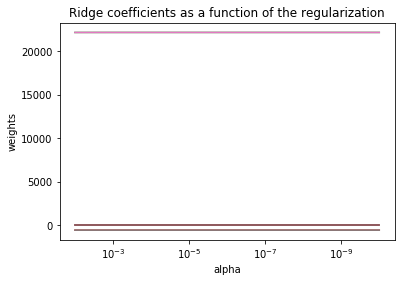

In [28]:
n_alphas = 100
alphas = np.logspace(-10, -2, n_alphas)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False, normalize=True)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
    ridge.fit(Xtrain, ytrain)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Do we need to standarized the data? One feature is staying high.. would it look better if we normalize it? Would the logarithm work better because it distributes the data better?

In [29]:
coefs[:5] #First five coefficients
#print(f'Last 5 coefficients: {coefs[(len(coefs) - 5):len(coefs)]}')

[array([ 1.25671073e-01,  2.83924392e-01,  2.21708862e+04, -5.96063139e+02]),
 array([ 1.25671073e-01,  2.83924392e-01,  2.21708862e+04, -5.96063139e+02]),
 array([ 1.25671073e-01,  2.83924392e-01,  2.21708862e+04, -5.96063139e+02]),
 array([ 1.25671073e-01,  2.83924392e-01,  2.21708862e+04, -5.96063139e+02]),
 array([ 1.25671073e-01,  2.83924392e-01,  2.21708862e+04, -5.96063139e+02])]

In [30]:
coefs[(len(coefs) - 5):len(coefs)] #the last 5 coefficients

[array([ 1.25665134e-01,  2.83928669e-01,  2.21695471e+04, -5.95994844e+02]),
 array([ 1.25663919e-01,  2.83929543e-01,  2.21692732e+04, -5.95980878e+02]),
 array([ 1.25662457e-01,  2.83930597e-01,  2.21689434e+04, -5.95964057e+02]),
 array([ 1.25660695e-01,  2.83931866e-01,  2.21685461e+04, -5.95943797e+02]),
 array([ 1.25658573e-01,  2.83933394e-01,  2.21680676e+04, -5.95919394e+02])]

In [31]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Instead of arbitrarily choosing alpha, we used cross-validation to choose the tuning parameter alpha. 

In [32]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)


RidgeCV(alphas=array([1.00000000e-10, 1.20450354e-10, 1.45082878e-10, 1.74752840e-10,
       2.10490414e-10, 2.53536449e-10, 3.05385551e-10, 3.67837977e-10,
       4.43062146e-10, 5.33669923e-10, 6.42807312e-10, 7.74263683e-10,
       9.32603347e-10, 1.12332403e-09, 1.35304777e-09, 1.62975083e-09,
       1.96304065e-09, 2.36448941e-09, 2.84803587e-09, 3.43046929e-09,
       4.13201240e-09, 4.97702356e-0...
       2.91505306e-04, 3.51119173e-04, 4.22924287e-04, 5.09413801e-04,
       6.13590727e-04, 7.39072203e-04, 8.90215085e-04, 1.07226722e-03,
       1.29154967e-03, 1.55567614e-03, 1.87381742e-03, 2.25701972e-03,
       2.71858824e-03, 3.27454916e-03, 3.94420606e-03, 4.75081016e-03,
       5.72236766e-03, 6.89261210e-03, 8.30217568e-03, 1.00000000e-02]),
        normalize=True, scoring='neg_mean_squared_error')

In [33]:
ridge_1 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge_1.fit(X_train, y_train)
yhat_ridge = ridge_1.predict(X_test)

# Evaluate the model
print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test, yhat_ridge))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, yhat_ridge))}')
print('Coefficient of determination: %.2f'% metrics.r2_score(y_test, yhat_ridge))

Mean squared error: 442044666.55
Root Mean Squared Error: 21024.858300368476
Coefficient of determination: 0.66


In [34]:
df_model_eval.loc[len(df.index)] = ['Ridge (Sales + Asset + Utilities + Timetrend)', metrics.mean_squared_error(y_test, yhat_ridge), np.sqrt(metrics.mean_squared_error(y_test, yhat_ridge)), metrics.r2_score(y_test, yhat_ridge)] 

#### Ridge Regression - Cross validation approach

In [35]:
kfold_cross_validation(10,X,y,ridge_1)

Mean squared error: 462009807.83
Root Mean Squared Error: 21494.413409662833
Coefficient of determination: 0.56


In [36]:
kfold_cross_validation(5,X,y,ridge_1)

Mean squared error: 458487743.03
Root Mean Squared Error: 21412.326894264337
Coefficient of determination: 0.57


In [37]:
kfold_cross_validation(2,X,y,ridge_1)

Mean squared error: 460942033.16
Root Mean Squared Error: 21469.56061878212
Coefficient of determination: 0.57


#### Lasso - Validation set approach

Text(0, 0.5, 'weights')

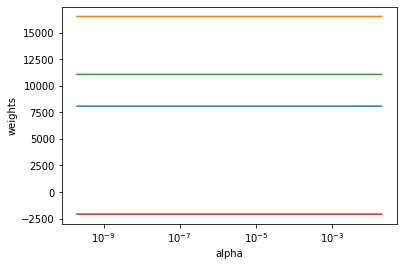

In [38]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [39]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

print(f'The optimal alpha is {lassocv.alpha_}')

The optimal alpha is 1.1532714502900596


In [40]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
yhat_lasso = lasso.predict(X_test)

# Evaluate the model
print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test, yhat_lasso))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, yhat_lasso))}')
print('Coefficient of determination: %.2f'% metrics.r2_score(y_test, yhat_lasso ))

Mean squared error: 442776564.91
Root Mean Squared Error: 21042.25664955323
Coefficient of determination: 0.66


In [41]:
df_model_eval.loc[len(df_model_eval.index)] = ['Lasso (Sales + Asset + Utilities + Timetrend)', metrics.mean_squared_error(y_test, yhat_lasso), np.sqrt(metrics.mean_squared_error(y_test, yhat_lasso)),metrics.r2_score(y_test, yhat_lasso ) ] 

#### Lasso Regression - Cross validation approach

In [42]:
kfold_cross_validation(10, X,y,lasso)

Mean squared error: 462209517.45
Root Mean Squared Error: 21499.058524807468
Coefficient of determination: 0.56


In [43]:
kfold_cross_validation(5, X,y,lasso)

Mean squared error: 458655027.23
Root Mean Squared Error: 21416.23279729868
Coefficient of determination: 0.57


### Model 4 -  GHG for Energy vs Utilities using natural logarithms


ln(GHG) = a + b1*ln(Sales) + b2*ln(Assets) + b3*ln(Util) + b5*ln(TimeTrend) + e

In [44]:
X=stock[['Logarithm_Total_Sales','Logarithm_Total_Assets','Utility','time_trend']]
y=stock['GHG Scope 1']

In [45]:
model = LinearRegression(fit_intercept=True) #Initialize model
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42) #Train and Test split
model.fit(Xtrain,ytrain) #Fit the model
y_model = model.predict(Xtest) #Make predictions

In [46]:
#The coefficients
print('Coefficients: \n', model.coef_)
#Mean Squared Error
print('Mean squared error: %.2f' % metrics.mean_squared_error(ytest,y_model))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(ytest,y_model))}')
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % metrics.r2_score(ytest, y_model))

Coefficients: 
 [11891.49071527 14604.97354257 26217.90450215  -632.58702587]
Mean squared error: 554112883.07
Root Mean Squared Error: 23539.602440878713
Coefficient of determination: 0.58


In [47]:
#Create data frame with observed and predicted
linear_reg4 = pd.DataFrame({'Observed':ytest,'Prediction':y_model})
linear_reg4.head()

,Observed,Prediction
418,3577.3,-10082.002711
778,119000.0,75597.535657
58,3410.0,-8221.854394
464,14296.5,5318.176349
206,32000.0,29450.977806


In [48]:
df_model_eval.loc[len(df_model_eval.index)] = ['Logarithm (Sales + Asset + Utilities + Timetrend)', metrics.mean_squared_error(ytest, y_model),np.sqrt(metrics.mean_squared_error(ytest, y_model)), metrics.r2_score(ytest, y_model)] 

#### Linear regression with k-fold cross validation

In [49]:
X = X.values
y = y.values

def kfold_cross_validation(n_splits, X, y, model_type):
    data_y, data_yhat,coef = [], [],[]
    kfold = KFold(n_splits=n_splits, random_state = 42, shuffle=True)
    for train_ix, test_ix in kfold.split(X):
        # get data
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        # fit model
        model = model_type
        model.fit(train_X, train_y)
        # make predictions
        yhat = model.predict(test_X)
        coef.append(model.coef_)
        # store
        data_y.extend(test_y)
        data_yhat.extend(yhat)

    # Evaluate the model
    print('Mean squared error: %.2f' % metrics.mean_squared_error(data_y, data_yhat))
    print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(data_y, data_yhat))}')
    print('Coefficient of determination: %.2f'% metrics.r2_score(data_y, data_yhat))

In [50]:
model1 = LinearRegression()
kfold_cross_validation(10,X,y,model1)

Mean squared error: 573588826.16
Root Mean Squared Error: 23949.71453183557
Coefficient of determination: 0.46


In [51]:
kfold_cross_validation(5,X,y,model1)

Mean squared error: 569033682.28
Root Mean Squared Error: 23854.426890567145
Coefficient of determination: 0.46


#### Ridge Regression - Validation set approach

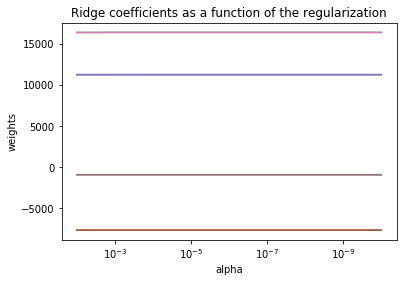

In [52]:
n_alphas = 100
alphas = np.logspace(-10, -2, n_alphas)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False, normalize=True)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
    ridge.fit(Xtrain, ytrain)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Do we need to standarized the data? One feature is staying high.. would it look better if we normalize it? Would the logarithm work better because it distributes the data better?

In [53]:
coefs[:5] #First five coefficients
#print(f'Last 5 coefficients: {coefs[(len(coefs) - 5):len(coefs)]}')

[array([11230.9303532 , -7677.62553281, 16361.82494703,  -938.61823508]),
 array([11230.93035319, -7677.62553281, 16361.82494702,  -938.61823508]),
 array([11230.93035318, -7677.6255328 , 16361.82494701,  -938.61823508]),
 array([11230.93035317, -7677.62553278, 16361.82494699,  -938.61823508]),
 array([11230.93035315, -7677.62553277, 16361.82494697,  -938.61823508])]

In [54]:
coefs[(len(coefs) - 5):len(coefs)] #the last 5 coefficients

[array([11228.97798009, -7675.64029429, 16359.16085854,  -938.69060806]),
 array([11228.57880385, -7675.23439844, 16358.61616101,  -938.70540492]),
 array([11228.09803565, -7674.74553711, 16357.96012411,  -938.72322614]),
 array([11227.51900814, -7674.15676236, 16357.1700025 ,  -938.74468946]),
 array([11226.82165374, -7673.44766878, 16356.21841015,  -938.77053862])]

In [55]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Instead of arbitrarily choosing alpha, we used cross-validation to choose the tuning parameter alpha. 

In [56]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)


RidgeCV(alphas=array([1.00000000e-10, 1.20450354e-10, 1.45082878e-10, 1.74752840e-10,
       2.10490414e-10, 2.53536449e-10, 3.05385551e-10, 3.67837977e-10,
       4.43062146e-10, 5.33669923e-10, 6.42807312e-10, 7.74263683e-10,
       9.32603347e-10, 1.12332403e-09, 1.35304777e-09, 1.62975083e-09,
       1.96304065e-09, 2.36448941e-09, 2.84803587e-09, 3.43046929e-09,
       4.13201240e-09, 4.97702356e-0...
       2.91505306e-04, 3.51119173e-04, 4.22924287e-04, 5.09413801e-04,
       6.13590727e-04, 7.39072203e-04, 8.90215085e-04, 1.07226722e-03,
       1.29154967e-03, 1.55567614e-03, 1.87381742e-03, 2.25701972e-03,
       2.71858824e-03, 3.27454916e-03, 3.94420606e-03, 4.75081016e-03,
       5.72236766e-03, 6.89261210e-03, 8.30217568e-03, 1.00000000e-02]),
        normalize=True, scoring='neg_mean_squared_error')

In [57]:
ridge_1 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge_1.fit(X_train, y_train)
yhat_ridge = ridge_1.predict(X_test)

# Evaluate the model
print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test, yhat_ridge))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, yhat_ridge))}')
print('Coefficient of determination: %.2f'% metrics.r2_score(y_test, yhat_ridge))

Mean squared error: 555343418.68
Root Mean Squared Error: 23565.725507147086
Coefficient of determination: 0.58


In [58]:
df_model_eval.loc[len(df_model_eval.index)] = ['Logarithm Ridge (Sales + Asset + Utilities + Timetrend)', metrics.mean_squared_error(y_test, yhat_ridge), np.sqrt(metrics.mean_squared_error(y_test, yhat_ridge)), metrics.r2_score(ytest, yhat_ridge)] 

In [59]:
df_model_eval.reset_index(inplace = True, drop = True)

#### Ridge Regression - Cross validation approach

In [60]:
kfold_cross_validation(10,X,y,ridge_1)

Mean squared error: 573558933.09
Root Mean Squared Error: 23949.090443900128
Coefficient of determination: 0.46


In [61]:
kfold_cross_validation(5,X,y,ridge_1)

Mean squared error: 569122863.08
Root Mean Squared Error: 23856.296088945717
Coefficient of determination: 0.46


In [62]:
kfold_cross_validation(2,X,y,ridge_1)

Mean squared error: 561973353.59
Root Mean Squared Error: 23705.977170057962
Coefficient of determination: 0.47


#### Lasso - Validation set approach

Text(0, 0.5, 'weights')

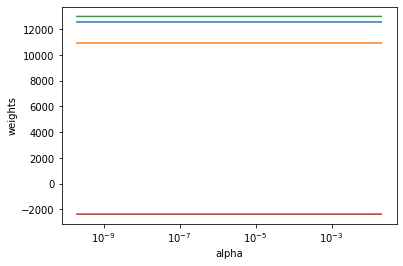

In [63]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [64]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

print(f'The optimal alpha is {lassocv.alpha_}')

The optimal alpha is 0.9954718896794498


In [65]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
yhat_lasso = lasso.predict(X_test)

# Evaluate the model
print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test, yhat_lasso))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, yhat_lasso))}')
print('Coefficient of determination: %.2f'% metrics.r2_score(y_test, yhat_lasso ))

Mean squared error: 554227879.45
Root Mean Squared Error: 23542.04492926017
Coefficient of determination: 0.58


#### Lasso Regression - Cross validation approach

In [66]:
kfold_cross_validation(10, X,y,lasso)

Mean squared error: 573604355.83
Root Mean Squared Error: 23950.0387439047
Coefficient of determination: 0.46


In [67]:
kfold_cross_validation(5, X,y,lasso)

Mean squared error: 569052835.46
Root Mean Squared Error: 23854.828346982482
Coefficient of determination: 0.46


### Conclusion - Models performance


All four predictive models had a big RSME when predicting the GHG Scope. Model 3 - had the lower RSME and the best R2 with 0.66.

However, we need to continue with other approach to work with the model performance or consider other ways to impute the missing values for GHG Scope 1

In [68]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [69]:
df_model_eval

,Model,MSE,RMSE,R-Squared
0,Linear (Sales + Asset),596373921.627,24420.768,0.548
1,Logarithmic (Sales + Asset),796139917.348,28215.951,0.396
2,Ridge (Sales + Asset + Utilities + Timetrend),442044666.551,21024.858,0.665
3,Lasso (Sales + Asset + Utilities + Timetrend),442776564.906,21042.257,0.664
4,Logarithm (Sales + Asset + Utilities + Timetrend),554112883.075,23539.602,0.580
5,Logarithm Ridge (Sales + Asset + Utilities + T...,555343418.678,23565.726,0.579


C:\Users\YEET\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


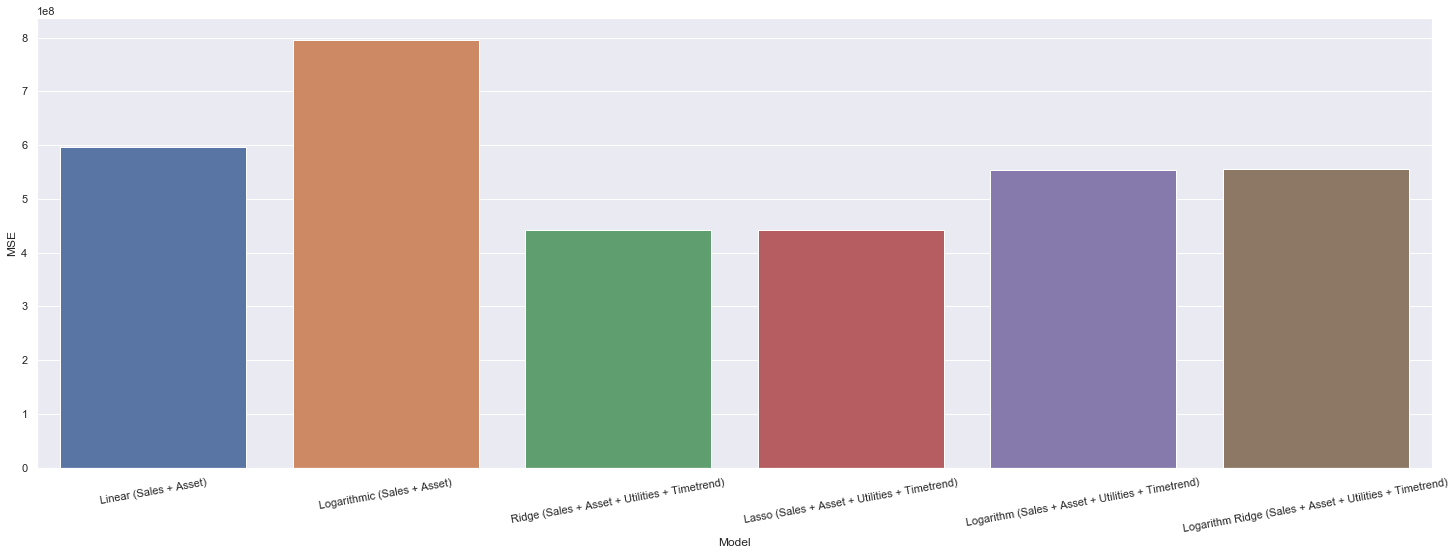

In [96]:
sns.set(rc={'figure.figsize':(25,8.27)})
g = sns.barplot('Model', 'MSE', data = df_model_eval)
for item in g.get_xticklabels():
    item.set_rotation(10)
    
g.figure.savefig('Model MSEs.png', bbox_inches='tight')

C:\Users\YEET\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


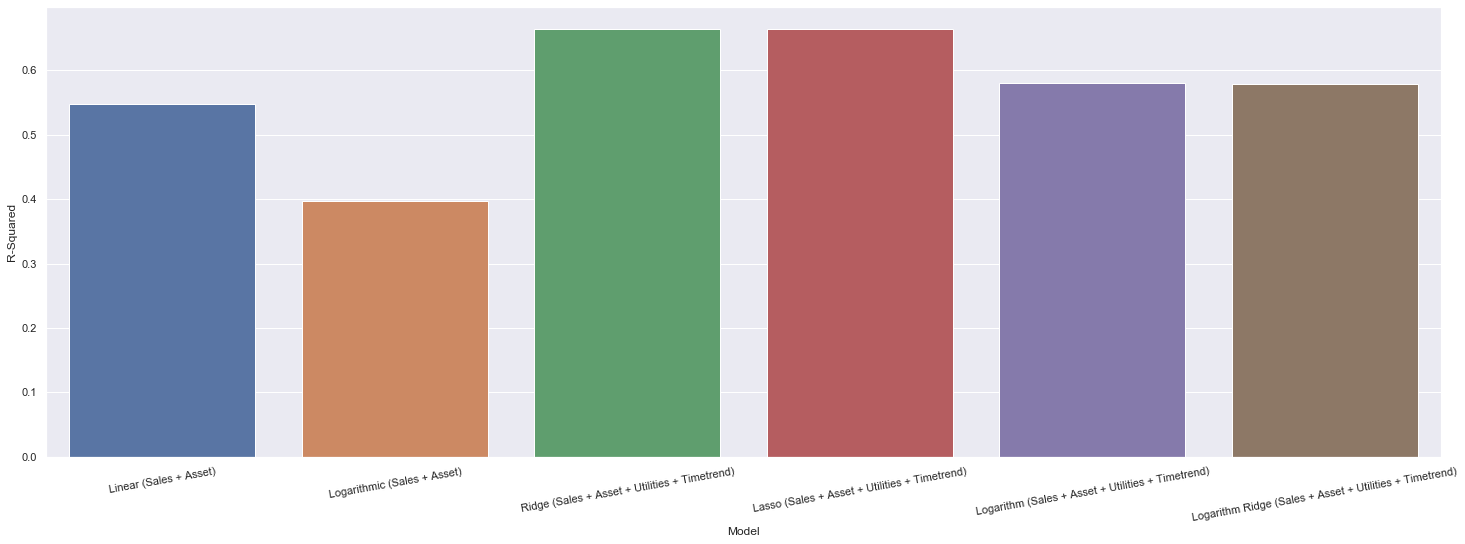

In [95]:
sns.set(rc={'figure.figsize':(25,8.27)})
g = sns.barplot('Model', 'R-Squared', data = df_model_eval)
for item in g.get_xticklabels():
    item.set_rotation(10)
    
g.figure.savefig('Model R-Squared.png', bbox_inches='tight')